# Where to eat in Chigago : an analysis of the inspections from the Chicago department of Public Health's Food Protection Programm

## 1. Introduction

The Chicago department of Public Health’s Food Protection Program provides a database which contains the information from inspection reports of restaurants and other food establishments in Chicago from 2010 to the present. It contains many informations about the establishments, like their type of facility (groceries’ stores, restaurants, coffee shop, …) and their locations. Many informations about the violations listed are also provided in the database, like the description of the findings that caused them and the reason that invoked the staff from the program to led an inspection.

In our project we endeavor to visualize the healthiness of public food establishments according to their type of facility, their ward and the date of the inspection. An analysis of the violation’s types according to these three parameters will also be conducted. 

The principal questions we'll answer are : 
    - Which ward of Chicago are the most healthy and unhealthy ? 
    - Which type of facility tend to be less healthy ? 
    - Did the healthiness of the food in Chicago increase or decrease from 2010 until now ?

New problematics could be asked during the analysis and would be added to these.

The purpose of the project is to help the consumer to easily choose where to eat in Chicago and to provide them an interactive and intuitive way to browse the different places offered to them. Also, it could help the Chicago department of Public Health’s Food Protection Program to adapt their methods relying on the situation described by the findings of the analysis (for example, if a prevention program should be proposed for a specific area or type of facility).

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import requests as req
from bs4 import BeautifulSoup
import seaborn as sns

## 2. Preprocessing

### 2.1 Selecting the facilities of interest

First a quick look at how is organized the dataset. 

In [2]:
df = pd.read_csv('food-inspections.csv',sep=',') #creation of the dataframe
df.head(3)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Results,Violations,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards
0,2320971,JUMPSTART EARLY LEARNING ACADEMY,JUMPSTART EARLY LEARNING ACADEMY,2589822.0,Children's Services Facility,Risk 1 (High),7559 W ADDISON ST,CHICAGO,IL,60634.0,...,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.945065,-87.816734,"{'longitude': '41.945064857019986', 'latitude'...",NaN,NaN,NaN,NaN,NaN
1,2320918,BEEFSTEAK,BEEFSTEAK,2698445.0,Restaurant,Risk 1 (High),303 E SUPERIOR ST,CHICAGO,IL,60611.0,...,Pass,39. CONTAMINATION PREVENTED DURING FOOD PREPAR...,41.895692,-87.620143,"{'longitude': '41.895692401410514', 'latitude'...",NaN,NaN,NaN,NaN,NaN
2,2320986,BABA'S COFFEE,BABA'S COFFEE,2423353.0,Restaurant,Risk 1 (High),5544-5546 N KEDZIE AVE,CHICAGO,IL,60625.0,...,No Entry,NaN,41.982582,-87.708996,"{'longitude': '41.98258181784537', 'latitude':...",NaN,NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195312 entries, 0 to 195311
Data columns (total 22 columns):
Inspection ID                 195312 non-null int64
DBA Name                      195312 non-null object
AKA Name                      192862 non-null object
License #                     195295 non-null float64
Facility Type                 190535 non-null object
Risk                          195239 non-null object
Address                       195312 non-null object
City                          195173 non-null object
State                         195270 non-null object
Zip                           195261 non-null float64
Inspection Date               195312 non-null object
Inspection Type               195311 non-null object
Results                       195312 non-null object
Violations                    143530 non-null object
Latitude                      194627 non-null float64
Longitude                     194627 non-null float64
Location                      194627 n

In [4]:
df.isnull().sum()

Inspection ID                      0
DBA Name                           0
AKA Name                        2450
License #                         17
Facility Type                   4777
Risk                              73
Address                            0
City                             139
State                             42
Zip                               51
Inspection Date                    0
Inspection Type                    1
Results                            0
Violations                     51782
Latitude                         685
Longitude                        685
Location                         685
Historical Wards 2003-2015    195312
Zip Codes                     195312
Community Areas               195312
Census Tracts                 195312
Wards                         195312
dtype: int64

It is a dataset of 195'312 entries with 22 columns listed above.

Now let's take a look at the missing values.

Text(0.5, 1.0, 'Missing values by column')

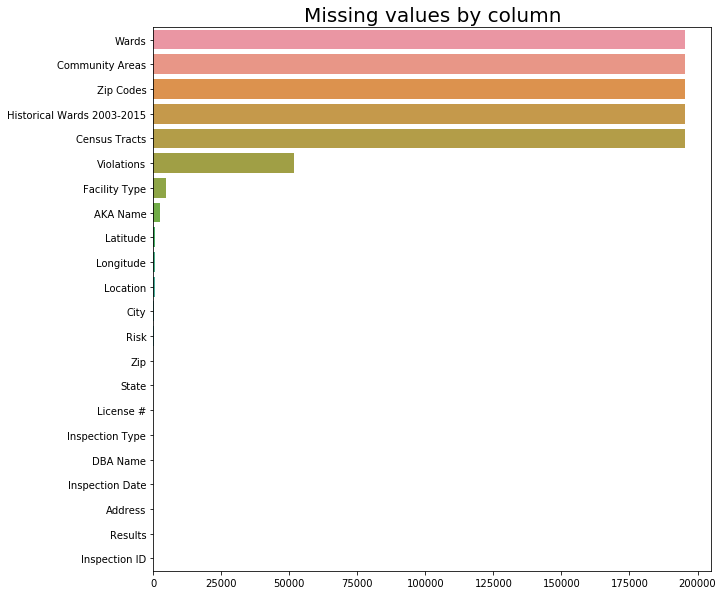

In [5]:
plt.figure(figsize=(10,10))
sns.barplot(x=df.isnull().sum().sort_values(ascending=False),y=df.isnull().sum().sort_values(ascending=False).index)
plt.title("Missing values by column",size=20)

In [6]:
## à faire seulement si vous voulez supprimer les valeurs nulles
#data=df.dropna(subset=['Violations','Facility Type','Latitude','Longitude','AKA Name'])
#data.isnull().sum()

In [7]:
#df['Facility Type'].unique()

A lot of different types of facility are found in the data.

First, we thought about only select the "private" establishments, where it is possible to eat a main course (for example, the places where you can only eat an ice cream are deleted of our list). They all are categorized in order to be compared with each other.


In [8]:
public_dic = {'restaurant' : ['Restaurant', 'DINING HALL', 'TENT RSTAURANT'], \
              'grocery_restaurant' : ['Grocery & Restaurant', 'GROCERY& RESTAURANT', 'GROCERY/RESTAURANT',\
                                    'GROCERY/ RESTAURANT', 'GROCERY STORE/ RESTAURANT', 'GROCERY & RESTAURANT',\
                                    'RESTAURANT/GROCERY', 'grocery & restaurant', 'RESTAURANT/GROCERY STORE',\
                                    'GROCERY/TAQUERIA', 'GAS STATION/RESTAURANT'],\
              'banquet' : ['LOUNGE/BANQUET HALL', 'BANQUET', 'Banquet Hall', 'BANQUET FACILITY', 'banquet hall',\
                         'banquets', 'Banquet Dining',  'Banquet/kitchen','RESTAURANT.BANQUET HALLS',\
                         'BANQUET HALL', 'Banquet', 'BOWLING LANES/BANQUETS'], \
              'rooftop_restaurant' : ['Wrigley Roof Top', 'REST/ROOFTOP'],\
              'bar_restaurant' : ['RESTAURANT/BAR', 'RESTUARANT AND BAR', 'BAR/GRILL', 'RESTAURANT/BAR/THEATER',\
                                'JUICE AND SALAD BAR', 'SUSHI COUNTER', 'TAVERN/RESTAURANT', 'tavern/restaurant',\
                                'TAVERN GRILL'], \
              'bakery_restaurant' : ['BAKERY/ RESTAURANT', 'bakery/restaurant', 'RESTAURANT/BAKERY'], \
              'liquor_restaurant' : ['RESTAURANT AND LIQUOR', 'RESTAURANT/LIQUOR'], \
              'catering' : ['CATERING/CAFE', 'Catering'], \
              'golden_diner' : ['Golden Diner']}

In [9]:
nombre = 0
for y in df['Facility Type'] :
    if y == 'Daycare (2 - 6 Years)' :
        nombre += 1
    else :
        pass
print(nombre)

2684


This command returns the number of occurencs of the `Facility Type` inputed. 

With trying different types previously categorized and listed in the `public_dic` dictionary we have noted that the results were too distant to conduct a meaningful analysis. That's why we then decided to also select "public" establishments like school cafeterias and hospitals. It could be interesting to compare private and public inspection results.


In [10]:
private_dic = {'daycare' : ['Daycare Above and Under 2 Years', 'Daycare (2 - 6 Years)', 'Daycare Combo 1586',\
                          'Daycare (Under 2 Years)', 'DAYCARE 2 YRS TO 12 YRS', 'Daycare Night', 'DAY CARE 2-14',\
                          'Daycare (2 Years)', 'DAYCARE', 'ADULT DAYCARE', '15 monts to 5 years old', 'youth housing',\
                          'DAYCARE 1586', 'DAYCARE COMBO', '1584-DAY CARE ABOVE 2 YEARS', 'CHURCH/DAY CARE', 'DAY CARE',\
                          'DAYCARE 6 WKS-5YRS', 'DAY CARE 1023', 'DAYCARE 2-6, UNDER 6', 'Day Care Combo (1586)'], \
               'school' : ['SCHOOL', 'School', 'PRIVATE SCHOOL', 'AFTER SCHOOL PROGRAM', 'COLLEGE',\
                         'BEFORE AND AFTER SCHOOL PROGRAM', 'Private School', 'TEACHING SCHOOL',\
                         'PUBLIC SHCOOL', 'CHARTER SCHOOL CAFETERIA', 'CAFETERIA', 'Cafeteria', 'cafeteria',\
                         'UNIVERSITY CAFETERIA', 'PREP INSIDE SCHOOL', 'CHARTER SCHOOL', 'school cafeteria',\
                         'CHARTER SCHOOL/CAFETERIA', 'School Cafeteria', 'ALTERNATIVE SCHOOL', 'CITY OF CHICAGO COLLEGE',\
                         'after school program', 'CHURCH/AFTER SCHOOL PROGRAM', 'AFTER SCHOOL CARE'], \
               'childrens_services' : ["Children's Services Facility", 'CHILDRENS SERVICES FACILITY', \
                                     "CHILDERN'S SERVICE FACILITY", "1023 CHILDREN'S SERVICES FACILITY", \
                                     "1023 CHILDERN'S SERVICES FACILITY", "1023-CHILDREN'S SERVICES FACILITY", \
                                     "1023 CHILDERN'S SERVICE FACILITY", "1023 CHILDERN'S SERVICE S FACILITY", \
                                     'CHILDERN ACTIVITY FACILITY', "CHILDERN'S SERVICES  FACILITY", '1023'], \
               'adultcare' : ['Long Term Care', 'REHAB CENTER', 'Hospital', 'ASSISTED LIVING', 'SENIOR DAY CARE',\
                            'Assisted Living', 'NURSING HOME', 'ASSISTED LIVING FACILITY', 'SUPPORTIVE LIVING FACILITY',\
                            'Assisted Living Senior Care', 'Adult Family Care Center', '1005 NURSING HOME', \
                            'Long-Term Care Facility', 'LONG TERM CARE FACILITY', 'ASSISSTED LIVING',\
                            'Long-Term Care','Long Term Care Facility', 'VFW HALL']}

In [11]:
total_dic = {**public_dic , **private_dic}

In [12]:
def newcolfromdict(dataf, dic, inputcolumn, outputcolumn) :
    new_list = []
    for content in dataf[inputcolumn] :
        new_content = 'Not listed'

        for k, v in dic.items() :
            if type(v) == list :
                for element in v :
                    if content == element :
                        new_content = k
            else :
                if content == v :
                    new_content = k

        new_list.append(new_content)
    dataf[outputcolumn] = new_list
    return dataf

The **newcolfromdict** function constructs a new column `outputcolum` from the inputed column `inputcolum` comparing its values to the `dic` dictionary and adds it to the `dataf` dataframe.

### Columns dropping

In [13]:
eat_seat = newcolfromdict(df, total_dic, 'Facility Type', 'Facility Group')

In [14]:
eat_seat = df.loc[df['Facility Group'] != 'Not Listed']
eat_seat = eat_seat.drop(columns = ['Facility Type', 'Historical Wards 2003-2015', 'Zip Codes', 'Community Areas', 'Census Tracts', 'Wards'])

eat_seat.head(2)

,Inspection ID,DBA Name,AKA Name,License #,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,Facility Group
0,2320971,JUMPSTART EARLY LEARNING ACADEMY,JUMPSTART EARLY LEARNING ACADEMY,2589822.0,Risk 1 (High),7559 W ADDISON ST,CHICAGO,IL,60634.0,2019-11-01T00:00:00.000,Canvass,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.945065,-87.816734,"{'longitude': '41.945064857019986', 'latitude'...",childrens_services
1,2320918,BEEFSTEAK,BEEFSTEAK,2698445.0,Risk 1 (High),303 E SUPERIOR ST,CHICAGO,IL,60611.0,2019-11-01T00:00:00.000,License,Pass,39. CONTAMINATION PREVENTED DURING FOOD PREPAR...,41.895692,-87.620143,"{'longitude': '41.895692401410514', 'latitude'...",restaurant


To construct the new dataframe the `Historical Wards 2003-2015`, `Zip Codes`, `Community Areas`, `Census Tracts` and `Wards` columns are dropped because mostly not completed, the `Facility Type` column is dropped because it has been replaced by the `Facility group`one and the *Not Listed* establishments are not selected.

In [15]:
print(len(eat_seat.index))    ##returns the number of rows of the df

195312


### Zip Codes cleaning

In [16]:
def clean_zip(zipcode):
    try :
        return int(float(zipcode))
    except :
        return 0

In [17]:
eat_seat.Zip = eat_seat.Zip.apply(clean_zip)    ##guarantees the zipcodes to be integers

We found a file associating the chicago zipe codes and their associated community area. Using it we can create a new `Community Area` column.

In [18]:
zip_to_area = pd.read_csv('ZipCode_to_ComArea.csv',sep=',') ##creation of the dataframe
zip_to_area = zip_to_area.drop(columns = ['TOT2010'])

zip_to_area.ZipCode = zip_to_area.ZipCode.apply(clean_zip) ##guarantees the zipcodes to be integers

zip_to_area = zip_to_area.groupby('ComArea')['ZipCode'].apply(list)    ##groups the zipcodes by community area number
zip_to_area = zip_to_area.reset_index()

In [19]:
zip_dic = zip_to_area.set_index('ComArea')['ZipCode'].to_dict()

In [20]:
eat_seat = newcolfromdict(eat_seat, zip_dic, 'Zip', 'Community Area')

In [21]:
eat_seat.head(3)

,Inspection ID,DBA Name,AKA Name,License #,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,Facility Group,Community Area
0,2320971,JUMPSTART EARLY LEARNING ACADEMY,JUMPSTART EARLY LEARNING ACADEMY,2589822.0,Risk 1 (High),7559 W ADDISON ST,CHICAGO,IL,60634,2019-11-01T00:00:00.000,Canvass,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.945065,-87.816734,"{'longitude': '41.945064857019986', 'latitude'...",childrens_services,76
1,2320918,BEEFSTEAK,BEEFSTEAK,2698445.0,Risk 1 (High),303 E SUPERIOR ST,CHICAGO,IL,60611,2019-11-01T00:00:00.000,License,Pass,39. CONTAMINATION PREVENTED DURING FOOD PREPAR...,41.895692,-87.620143,"{'longitude': '41.895692401410514', 'latitude'...",restaurant,8
2,2320986,BABA'S COFFEE,BABA'S COFFEE,2423353.0,Risk 1 (High),5544-5546 N KEDZIE AVE,CHICAGO,IL,60625,2019-11-01T00:00:00.000,Canvass,No Entry,NaN,41.982582,-87.708996,"{'longitude': '41.98258181784537', 'latitude':...",restaurant,14


In [22]:
pb = 0
for zipcode in eat_seat.Zip :
    if zipcode == 0 : 
        pb += 1
print(pb)

51


The **clean_zip()** function returns **0** if the zip code is not convertible into an integer. Here it means that there are 51 missing zip codes in the `Zip` column, so we need to complete the data using the other informations available.
We found a dataset online which contains all the US zip code and the longitude and latitude associated. Only the Chicago zip codes have been kept.


In [23]:
ziplatlong = pd.read_csv('ZipLatLong.csv',sep=',')
ziplatlong.head()

,ZIP,LAT,LNG
0,60007,42.008600,-87.997340
1,60008,42.069786,-88.016221
2,60010,42.146494,-88.164651
3,60012,42.272492,-88.314084
4,60013,42.223439,-88.235506


### Managing the changes in the Food Code Rules

The Food Code Rules has changed since the 1st July 2018. 

The following code returns every unique entry in the considered column : 

In [24]:
#eat_seat.Violations.unique()

In [25]:
len(eat_seat.Violations.unique())

142510

It seems that every violation is a unique entry because it contains not only the violation type but also the comments of the inspectors. We have to split the Violations column into 3 different columns :
- Violation number
- Violation type
- Violation comments

It seems that every violation cell is architectured this way :
"number of the violation". "TYPE OF THE VIOLATION" - Comments : "comments of the inspector"

We can also try to split each line in three, separating the numbers (taking each character until the character "."), then separating the violation type (every following character until the character "-"), and the rest of the characters would be the comments of the inspector. 

In [26]:
eat_seat['Violations'][0]

'5. PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS - Comments: OBSERVED INCOMPLETE CLEAN UP KIT ON SITE.INSTRUCTED MANAGEMENT TO HAVE A COMPLETE CLEAN UP KIT BY NEXT INSPECTION.CLEAN UP PROCEDURES  ON SITE PRIORITY FOUNDATION VIOLATION  7-38-005   NO CITATION ISSUED | 10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE - Comments: OBSERVED EXPOSED HAND SINK NOT ACCESSIBLE FOR HANDWASHING IN THE FOOD PREP AREA.INSTRUCTED MANAGEMENT TO INSTALL EXPOSED HAND SINK AT A LOCATION THAT IS ACCESSIBLE. PRIORITY FOUNDATION VIOLATION 7-38-030(c) NO CITATION ISSUED | 56. ADEQUATE VENTILATION & LIGHTING; DESIGNATED AREAS USED - Comments: OBSERVED HOT LINE HOOD FILTERS DUSTY.INSTRUCTED MANAGEMENT TO CLEAN HOT LINE HOOD FILTERS.'

Actually it seems that it is not a good idea because there is more than one violation in every Violations cell. 

In [27]:
eat_seat['Violations'] = eat_seat.Violations.apply(lambda x : str(x))

eat_seat['Violations'] = eat_seat.Violations.apply(lambda x : x.split("."))

eat_seat['Violations'][0]

['5',
 ' PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS - Comments: OBSERVED INCOMPLETE CLEAN UP KIT ON SITE',
 'INSTRUCTED MANAGEMENT TO HAVE A COMPLETE CLEAN UP KIT BY NEXT INSPECTION',
 'CLEAN UP PROCEDURES  ON SITE PRIORITY FOUNDATION VIOLATION  7-38-005   NO CITATION ISSUED | 10',
 ' ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE - Comments: OBSERVED EXPOSED HAND SINK NOT ACCESSIBLE FOR HANDWASHING IN THE FOOD PREP AREA',
 'INSTRUCTED MANAGEMENT TO INSTALL EXPOSED HAND SINK AT A LOCATION THAT IS ACCESSIBLE',
 ' PRIORITY FOUNDATION VIOLATION 7-38-030(c) NO CITATION ISSUED | 56',
 ' ADEQUATE VENTILATION & LIGHTING; DESIGNATED AREAS USED - Comments: OBSERVED HOT LINE HOOD FILTERS DUSTY',
 'INSTRUCTED MANAGEMENT TO CLEAN HOT LINE HOOD FILTERS',
 '']

`****  PB A PARTIR DE LA CELL SUIVANTE PAS MEMES RESULTATS QUE DANS CLAIRE  ****`

In [28]:

len(eat_seat['Violations'][0])

10

In [29]:
eat_seat['ViolationNumber'] = eat_seat.Violations.apply(lambda x : x[0])

eat_seat['ViolationNumber'][0]

'5'

In [30]:


eat_seat['Violations'] = eat_seat.Violations.apply(lambda x : x[1])

eat_seat['Violations'] = eat_seat.Violations.apply(lambda x : x.split("-"))

eat_seat['ViolationType'] = eat_seat.Violations.apply(lambda x : x[0])

eat_seat['ViolationComment'] = eat_seat.Violations.apply(lambda x : x[1])


IndexError: list index out of range

In [ ]:
violators = eat_seat.dropna(subset=['Violations'], axis = 0, how = 'all')
violations = violators.apply(lambda row: re.findall('\|\s([0-9]+)[.]', str(row['Violations'])), axis = 1)
first_violations = violators.apply(lambda row: row['Violations'].split('.')[0], axis = 1)

for violation, first_violation in zip(violations, first_violations):
    violation.append(first_violation)

flat_list = [item for sublist in violations for item in sublist]
unique, counts = np.unique(flat_list, return_counts=True)

In [ ]:
violations